In [1]:
import pandas as pd
import numpy as np
from glob import  glob
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import xarray as xr
from sklearn.cluster import KMeans
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from collections import defaultdict
import matplotlib.patches as mpatches
import geopandas as gpd
from shapely.geometry import Polygon

from scipy.ndimage import gaussian_filter

In [2]:
target_time = pd.date_range('19910101','20201231',freq='d')
df_times = pd.DataFrame({'index': target_time}, index=target_time)
df_times = df_times.drop(index=df_times[(df_times.index.day==29) & (df_times.index.month==2)].index)

paths = glob('data/raw/*')

def fix_name(d):
    return d.split(':')[-1].replace('\n','')[1:]

In [3]:
n_total_days = len(df_times)
print(f"observações esperadas {n_total_days}")

observações esperadas 10950


In [34]:
metadata = defaultdict(list)
dfs = list()
for p in paths:
    
    with open(p) as file:
        data = file.readlines()
        names = ['name', 'cod', 'lat', 'lon', 'alt', 'status', 'init_at', 'end_at', 'freq']
        values = [fix_name(d) for d in data[:9]]
        cfg = dict(zip(names, values))
        for ky, vl in cfg.items():
            metadata[ky].append(vl)

    df = pd.read_csv(p, sep=';', na_values=['-9999.0','null'], skiprows=9)

    for name, value in cfg.items():
        df[name] = value
    
    df.index = pd.to_datetime(df['Data Medicao'].values)
    df = df.loc['1991-01-01':'2020-12-31']
    df = df.drop(index=df[(df.index.day==29) & (df.index.month==2)].index)
    df = df_times.combine_first(df)

    
    calculed_tmed = df[['TEMPERATURA MAXIMA, DIARIA(°C)', 'TEMPERATURA MINIMA, DIARIA(°C)']].dropna().mean(axis=1)
    compensed_tmed = df['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)'].dropna()
    tmed = calculed_tmed.combine_first(compensed_tmed)
    main_df = pd.DataFrame({'tmean': tmed}, index=pd.to_datetime(tmed.index))
    main_df = df_times.combine_first(main_df)
    
    df['tmean'] = main_df['tmean'].copy()
    
    total = len(main_df)
    total_nan = len(main_df) - len(main_df.dropna())
    percent_null = total_nan/total * 100
    
    df['percent_null'] = round(float(percent_null), 1)
    df = df.sort_values('index')
    metadata['percent_null'].append(round(float(percent_null), 1))
    if percent_null <= 11:       

        assert len(df) == n_total_days
        dfs.append(df)  

In [35]:
metadata = pd.DataFrame(metadata)
len(metadata)

57

In [36]:
metadata

,name,cod,lat,lon,alt,status,init_at,end_at,freq,percent_null
0,CAXIAS DO SUL,83942,-29.1961111,-51.18638888,750.16,Operante,1990-01-01,2025-02-16,Diaria,7.0
1,CANELA,83944,-29.37,-50.8,830,Desativada,1990-01-01,1990-09-30,Diaria,100.0
2,CAMBARA DO SUL,83946,-29.04916666,-50.14972221,1015.97,Fechada,1990-01-01,2021-07-24,Diaria,22.6
3,TORRES,83948,-29.35027777,-49.71666666,4.66,Fechada,1990-01-01,2021-04-26,Diaria,7.2
4,NOVO HAMBURGO,83951,-29.97,-51.13,35,Desativada,1990-01-01,1998-12-31,Diaria,80.9
5,SANTANA DO LIVRAMENTO,83953,-30.842617,-55.613073,328.22,Desativada,1990-01-01,2013-12-16,Diaria,51.2
6,TRIUNFO,83954,-29.869757,-51.379201,23.6,Desativada,1990-01-01,2013-06-29,Diaria,35.0
7,CAMPO BOM,83961,-29.677684,-51.049914,28.96,Desativada,1990-01-01,2013-11-29,Diaria,24.0
8,ENCRUZILHADA DO SUL,83964,-30.54305555,-52.52472221,427.75,Fechada,1990-01-01,2021-07-24,Diaria,4.1
9,PORTO ALEGRE,83967,-30.05361111,-51.17476666,41.18,Operante,1990-01-01,2025-02-16,Diaria,0.0


In [37]:
# z = xr.open_dataset('/media/lucaspc/HD/statics/etopo_0p01.nc')['z']

/tmp/ipykernel_5491/2117529596.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_geometry = gdf_states.unary_union
/tmp/ipykernel_5491/2117529596.py:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color='green', label='< 10% nulos', alpha=0.9, edgecolor='black'),
/tmp/ipykernel_5491/2117529596.py:73: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color='orange', label='10-20% nulos', alpha=0.9, edgecolor='black'),
/tmp/ipykernel_5491/2117529596.py:74: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color='red', label='> 20% nulos', alpha=0.9, edgecolor='black')


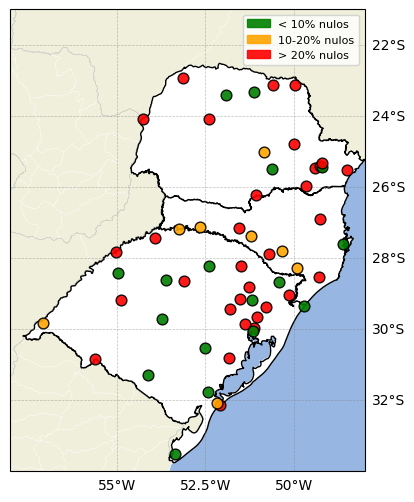

In [38]:
fig = plt.figure(#dpi=300
                 figsize=(8,6))#
extent = (-58, -48.02308, -34, -21)
ax = plt.subplot(111, projection=ccrs.PlateCarree())
# z = xr.open_dataset('/media/lucaspc/HD/statics/etopo_0p01.nc')['z']
# z = xr.where(z<0, np.nan, z)
ax.add_feature(cfeature.LAND, edgecolor='white', linewidth=0.2)
ax.add_feature(cfeature.BORDERS, linewidth=0.2)
ax.add_feature(cfeature.OCEAN, edgecolor='white', linewidth=0.2)
ax.add_feature(cfeature.STATES, edgecolor='white', linewidth=0.2)
ax.set_extent(extent)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-55, -34, -52.5, -26, -50])
gl.left_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}


geojson_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
gdf = gpd.read_file(geojson_url)

states_of_interest = ['Rio Grande do Sul', 'Santa Catarina', 'Paraná']
gdf_states = gdf[gdf['name'].isin(states_of_interest)]

for _, state in gdf_states.iterrows():
    state_geometry = state['geometry']
    ax.add_geometries([state_geometry], crs=ccrs.PlateCarree(),
                      facecolor='white', edgecolor='black', linewidth=1)

combined_geometry = gdf_states.unary_union


legend_handles = []

counter = {
    'null<=10': 0,
    '10<null<=20': 0,
    'null>20': 0
}


for i, _md in metadata[['cod', 'lat', 'lon', 'alt', 'percent_null', 'status']].iterrows():
    _md.iloc[:-1] = _md.iloc[:-1].astype('float')
    if _md.percent_null <= 10:
        color = 'green'
        counter['null<=10'] += 1
    elif (_md.percent_null > 10) and (_md.percent_null <= 20):
        color = 'orange'
        counter['10<null<=20'] += 1
    elif _md.percent_null > 20:
        color = 'red'
        counter['null>20'] += 1
        
    ax.scatter(_md.lon, _md.lat, color=color, s=60, zorder=5, marker='o', alpha=0.9, edgecolor='black')

min_lon, max_lon, min_lat, max_lat = extent


# z_cropped = z.sel(longitude=slice(min_lon, max_lon), latitude=slice(min_lat, max_lat))

# sigma = 2  # ajuste o valor conforme necessário
# z_gaussian = gaussian_filter(z_cropped, sigma=sigma)

# contour = ax.contour(z_cropped.longitude, z_cropped.latitude, z_gaussian, colors='black', levels=np.arange(200,1200,300), linestyles='--', linewidths=0.2)
# ax.clabel(contour, inline=True, inline_spacing=5, fontsize=10, fmt='%1.0f', colors='black', zorder=99)


legend_handles = [
    mpatches.Patch(color='green', label='< 10% nulos', alpha=0.9, edgecolor='black'),
    mpatches.Patch(color='orange', label='10-20% nulos', alpha=0.9, edgecolor='black'),
    mpatches.Patch(color='red', label='> 20% nulos', alpha=0.9, edgecolor='black')
]
ax.legend(handles=legend_handles, loc='best', fontsize=8)
plt.savefig('images/todasestacoes.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [39]:
counter

{'null<=10': 17, '10<null<=20': 8, 'null>20': 32}

In [40]:
sel_columns = [
    'Data Medicao', 
    'PRECIPITACAO TOTAL, DIARIO(mm)',
    'TEMPERATURA MAXIMA, DIARIA(°C)',
    #'TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)',
    'tmean',
    'TEMPERATURA MINIMA, DIARIA(°C)',
    'UMIDADE RELATIVA DO AR, MEDIA DIARIA(%)', 
    'cod', 
    'lat', 
    'lon', 
    'alt',
    'name',
    'percent_null'
]
rename_cols = {
    'Data Medicao':'datas', 
    'PRECIPITACAO TOTAL, DIARIO(mm)':'prec',
    'TEMPERATURA MAXIMA, DIARIA(°C)':'tmax',
    #'TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)':'tmean',
    'TEMPERATURA MINIMA, DIARIA(°C)':'tmin',
    'UMIDADE RELATIVA DO AR, MEDIA DIARIA(%)':'ur', 
}
df_concat = pd.concat(dfs)
df_concat = df_concat.loc[:, sel_columns].rename(columns=rename_cols)
df_concat['day_of_year'] = np.nan
df_concat['p95'] = np.nan
df_concat['p90'] = np.nan
df_concat['mean'] = np.nan

In [41]:
df_concat

,datas,prec,tmax,tmean,tmin,ur,cod,lat,lon,alt,name,percent_null,day_of_year,p95,p90,mean
1991-01-01,1991-01-01,0.0,NaN,NaN,NaN,NaN,83942,-29.1961111,-51.18638888,750.16,CAXIAS DO SUL,7.0,NaN,NaN,NaN,NaN
1991-01-02,1991-01-02,0.0,28.7,NaN,NaN,NaN,83942,-29.1961111,-51.18638888,750.16,CAXIAS DO SUL,7.0,NaN,NaN,NaN,NaN
1991-01-03,1991-01-03,0.0,24.6,NaN,NaN,NaN,83942,-29.1961111,-51.18638888,750.16,CAXIAS DO SUL,7.0,NaN,NaN,NaN,NaN
1991-01-04,1991-01-04,0.0,24.0,NaN,NaN,NaN,83942,-29.1961111,-51.18638888,750.16,CAXIAS DO SUL,7.0,NaN,NaN,NaN,NaN
1991-01-05,1991-01-05,0.0,26.4,NaN,NaN,NaN,83942,-29.1961111,-51.18638888,750.16,CAXIAS DO SUL,7.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,2020-12-27,0.0,27.8,22.40,17.0,79.3,83836,-25.50277777,-50.63749999,881.69,IRATI,3.4,NaN,NaN,NaN,NaN
2020-12-28,2020-12-28,0.0,28.1,22.50,16.9,85.5,83836,-25.50277777,-50.63749999,881.69,IRATI,3.4,NaN,NaN,NaN,NaN
2020-12-29,2020-12-29,0.6,26.6,22.05,17.5,89.3,83836,-25.50277777,-50.63749999,881.69,IRATI,3.4,NaN,NaN,NaN,NaN
2020-12-30,2020-12-30,1.5,29.8,23.30,16.8,77.3,83836,-25.50277777,-50.63749999,881.69,IRATI,3.4,NaN,NaN,NaN,NaN


In [42]:
codes = df_concat.cod.dropna().unique()
names = [df_concat[df_concat.cod==code].name.iloc[0] for code in codes]
lons = [float(df_concat[df_concat.cod==code].lon.iloc[0]) for code in codes]
lats = [float(df_concat[df_concat.cod==code].lat.iloc[0]) for code in codes]
alt = [float(df_concat[df_concat.cod==code].alt.iloc[0]) for code in codes]
percent_null = [float(df_concat[df_concat.cod==code].percent_null.iloc[0]) for code in codes]
cidades = pd.DataFrame(dict(names=names, lons=lons, lats=lats, alt=alt, percent_null=percent_null), index=codes)

In [43]:
len(cidades)

18

In [44]:
assert len(df_concat) == len(cidades) * n_total_days

In [45]:
# correction year_of_day because we ignoring 02/29 when is leapyear
for i in tqdm(range(len(df_concat))):
    
    index = df_concat.index[i]
    assert isinstance(index, pd.Timestamp)
    
    day_of_year = index.day_of_year
    is_leap_year = calendar.isleap(index.year)
    
    if is_leap_year:
        if day_of_year >= 60:
            day_of_year -= 1

    df_concat.loc[index, 'day_of_year'] = int(day_of_year)

100%|█████████████████████████████████| 197100/197100 [01:13<00:00, 2665.15it/s]


In [46]:
df_clim = list()
df_done = list()
for code in codes:
    df_sel = df_concat[df_concat.cod==code].copy()

    try:
        assert len(df_sel) == n_total_days
    except:
        df_sel = df_times.combine_first(df_sel)
    
    days = df_sel.day_of_year.dropna().unique()
    _df = pd.DataFrame()
    _df['mean'] = df_sel.loc[:, 'tmean'].groupby(by=df_sel.day_of_year).mean()
    _df['p90'] = df_sel.loc[:, 'tmean'].groupby(by=df_sel.day_of_year).quantile(0.9)
    _df['p95'] = df_sel.loc[:, 'tmean'].groupby(by=df_sel.day_of_year).quantile(0.95)
    _df['code'] = code

    for day in days:
        df_sel.loc[df_sel.day_of_year==day, 'mean'] = _df.loc[day, 'mean']
        df_sel.loc[df_sel.day_of_year==day, 'p90'] = _df.loc[day, 'p90']
        df_sel.loc[df_sel.day_of_year==day, 'p95'] = _df.loc[day, 'p95']

    assert len(df_sel) == n_total_days
    
    df_done.append(df_sel)
    df_clim.append(_df)
    
df_clim = pd.concat(df_clim).reset_index()
df_done = pd.concat(df_done)

df_done['anom_p95'] = df_done['tmean'] - df_done['p95']
df_done['anom_p90'] = df_done['tmean'] - df_done['p90']
df_done['anom_mean'] = df_done['tmean'] - df_done['mean']

In [47]:
assert len(df_done) == len(cidades) * n_total_days

In [48]:
assert len(df_clim) == len(cidades) * 365

In [49]:
#df_done.loc[(df_done.day_of_year==221) & (df_done.name=='CAXIAS DO SUL')]['tmean'].mean()

In [50]:
#df_done.loc[(df_done.day_of_year==221) & (df_done.name=='CAXIAS DO SUL')]

In [51]:
#df_done[df_done.index.month.isin([6,7,8,9,10])]

In [52]:
def extract(codes, df_done, variable, fillna=True):
    dfs = list()
    for i, code in tqdm(enumerate(codes)):
        
        df_code = df_done[df_done['cod']==code]
        df_code = df_times.combine_first(df_code)
        
        info = df_code.loc[:, ['name', 'cod', 'lat', 'lon', 'alt']]

        if fillna:
            df_code[variable] = df_code[variable].fillna(df_code[variable].mean())
                
        _df = pd.DataFrame({code:df_code[variable].values}, index=df_code['index']).T
        dfs.append(_df)
        
    return pd.concat(dfs)

In [53]:
anom_data = extract(codes, df_done, variable='anom_mean')
tmean_data = extract(codes, df_done, variable='tmean')

18it [00:00, 26.32it/s]
18it [00:00, 26.41it/s]


In [54]:
assert anom_data.shape[0] == len(cidades)
assert anom_data.shape[1] == n_total_days

In [55]:
def fancy_dendrogram(ax, *args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(ax=ax, *args, **kwargs)

    if not kwargs.get('no_plot', False):
        #plt.title('Dendograma')
        ax.set_xlabel('Estações')
        ax.set_ylabel('Distâncias')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                ax.plot(x, y, 'o', c=c)
                ax.annotate("%.4g" % round(y,0), (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            ax.axhline(y=max_d, c='k')
            
    return ddata

Melhor número de clusters: 2


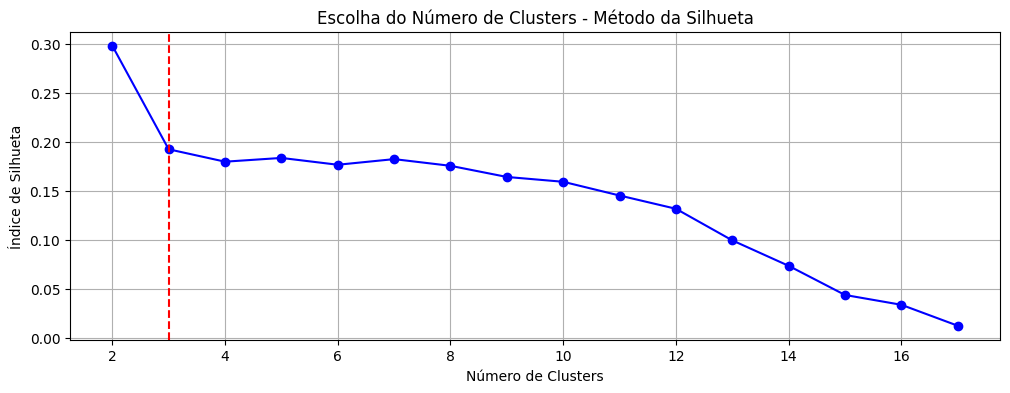

In [56]:
import numpy as np
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score

# Calculando a matriz de ligação (linkage)
Z = sch.linkage(anom_data.values, method='ward')

# Testando diferentes números de clusters
silhouettes = []
K = range(2, 18)

for k in K:
    labels = sch.fcluster(Z, k, criterion='maxclust')
    score = silhouette_score(anom_data.values, labels)
    silhouettes.append(score)

# Encontrando o melhor número de clusters
best_k = K[np.argmax(silhouettes)]
print(f"Melhor número de clusters: {best_k}")

# Plotando o índice de silhueta
plt.figure(figsize=(12, 4))
plt.plot(K, silhouettes, marker='o', linestyle='-', color='b')
plt.xlabel("Número de Clusters")
plt.ylabel("Índice de Silhueta")
plt.title("Escolha do Número de Clusters - Método da Silhueta")
plt.grid(True)

# Destacando o melhor k
best_k = K[np.argmax(silhouettes)]
plt.axvline(3, color='r', linestyle='--')
#lt.legend()

plt.show()

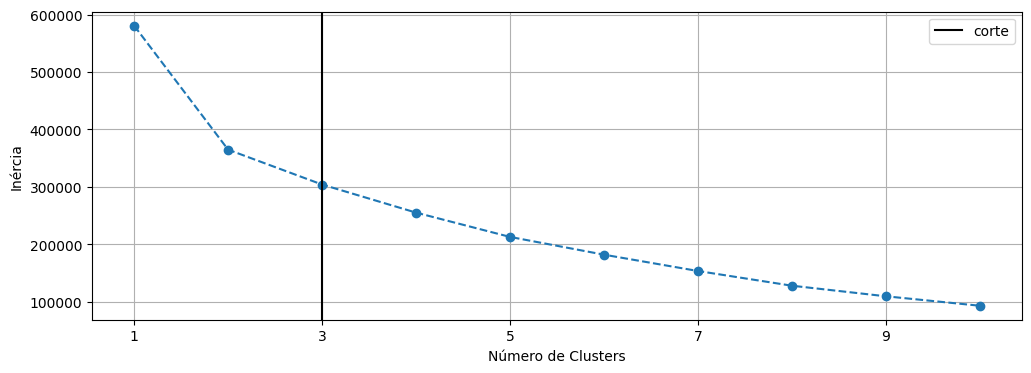

[np.float64(580622.7592312644), np.float64(364767.33262077026), np.float64(304057.08412224933), np.float64(255180.0347800199), np.float64(212859.05683032412), np.float64(181934.8149484545), np.float64(153516.41996056604), np.float64(127896.08608397089), np.float64(109477.05475308945), np.float64(93007.95693405019)]


In [75]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

def elbow_method_ward(data, max_clusters=10):
    """
    Aplica o método do cotovelo para encontrar o número ideal de clusters
    utilizando a ligação Ward no scipy.
    
    Parâmetros:
    - data: array-like, conjunto de dados de entrada.
    - max_clusters: int, número máximo de clusters a serem avaliados.
    
    Retorna:
    - Nenhum, mas plota o gráfico do método do cotovelo.
    """
    # Calcula a matriz de linkage usando o método de Ward
    Z = sch.linkage(data, method='ward')
    
    wcss = []
    k_values = range(1, 11)
    
    for k in k_values:
        clusters = fcluster(Z, k, criterion='maxclust')
        centroids = np.array([data[clusters == i].mean(axis=0) for i in range(1, k + 1)])
        wcss.append(sum(np.sum((data[clusters == i] - centroids[i - 1]) ** 2) for i in range(1, k + 1)))
    
    # Plota o método do cotovelo
    plt.figure(figsize=(12, 4))
    plt.plot(list(range(1, max_clusters + 1)), wcss, marker='o', linestyle='--')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inércia')
    plt.grid(True)
    plt.axvline(x=3, color='black', label='corte')
    plt.legend()
    plt.savefig('elbow.png')
    plt.xticks(list(range(1, max_clusters + 1, 2)))
    plt.show()
    print(wcss)

elbow_method_ward(anom_data.values, max_clusters=10)


100000.0

Melhor número de clusters: 2


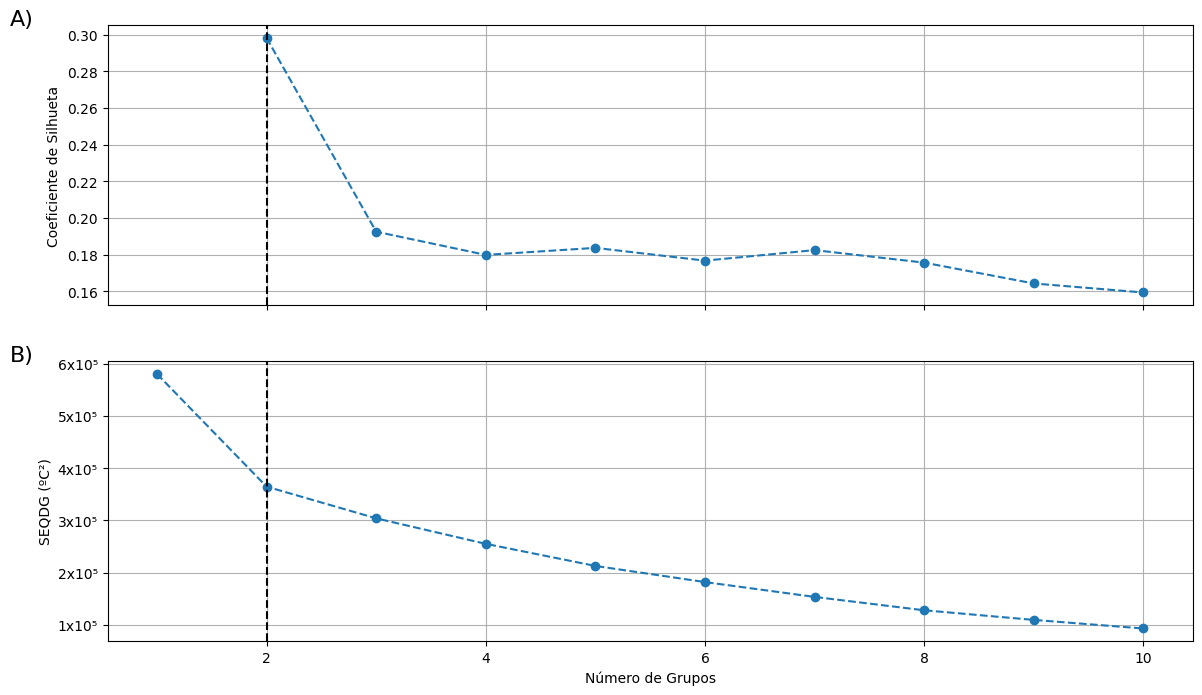

In [115]:
import numpy as np
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score

data = anom_data.values
#fig = plt.figure(figsize=(12,6))
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,8), sharex=True)
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
# Calculando a matriz de ligação (linkage)
Z1 = sch.linkage(anom_data.values, method='ward')
silhouettes = []
K = range(2, 11)
for k in K:
    labels = sch.fcluster(Z, k, criterion='maxclust')
    score = silhouette_score(data, labels)
    silhouettes.append(score)
best_k = K[np.argmax(silhouettes)]
print(f"Melhor número de clusters: {best_k}")

ax1.plot(K, silhouettes, marker='o', linestyle='--')
ax1.set_ylabel("Coeficiente de Silhueta")
ax1.grid(True)
best_k = K[np.argmax(silhouettes)]
ax1.axvline(x=best_k, color='black', linestyle='--', label=f'Corte (k={best_k})')




# Calcula a matriz de linkage usando o método de Ward
Z2 = sch.linkage(data, method='ward')

# Calcula a inércia para diferentes números de clusters
wcss = []
k_values = range(1, 11)

for k in k_values:
    clusters = fcluster(Z, k, criterion='maxclust')
    centroids = np.array([data[clusters == i].mean(axis=0) for i in range(1, k + 1)])
    wcss.append(sum(np.sum((data[clusters == i] - centroids[i - 1]) ** 2) for i in range(1, k + 1)))
# Plotagem
ax2.plot(k_values, wcss, marker='o', linestyle='--')
ax2.set_xlabel('Número de Grupos')
ax2.set_ylabel('SEQDG (ºC²)')
ax2.grid(True)
ax2.axvline(x=2, color='black', linestyle='--', label=f'Corte (k={2})')
#ax2.legend()
ax2.set_yticks([100000,200000,300000,400000,500000,600000],['1x10⁵', '2x10⁵', '3x10⁵', '4x10⁵', '5x10⁵', '6x10⁵'])
ax1.annotate('A)', xy=(-0.09, 1), xycoords='axes fraction', color='black', fontsize=16)
ax2.annotate('B)', xy=(-0.09, 1), xycoords='axes fraction', color='black', fontsize=16)
    

plt.savefig('elbow.pdf', format='pdf', bbox_inches='tight')
plt.show()


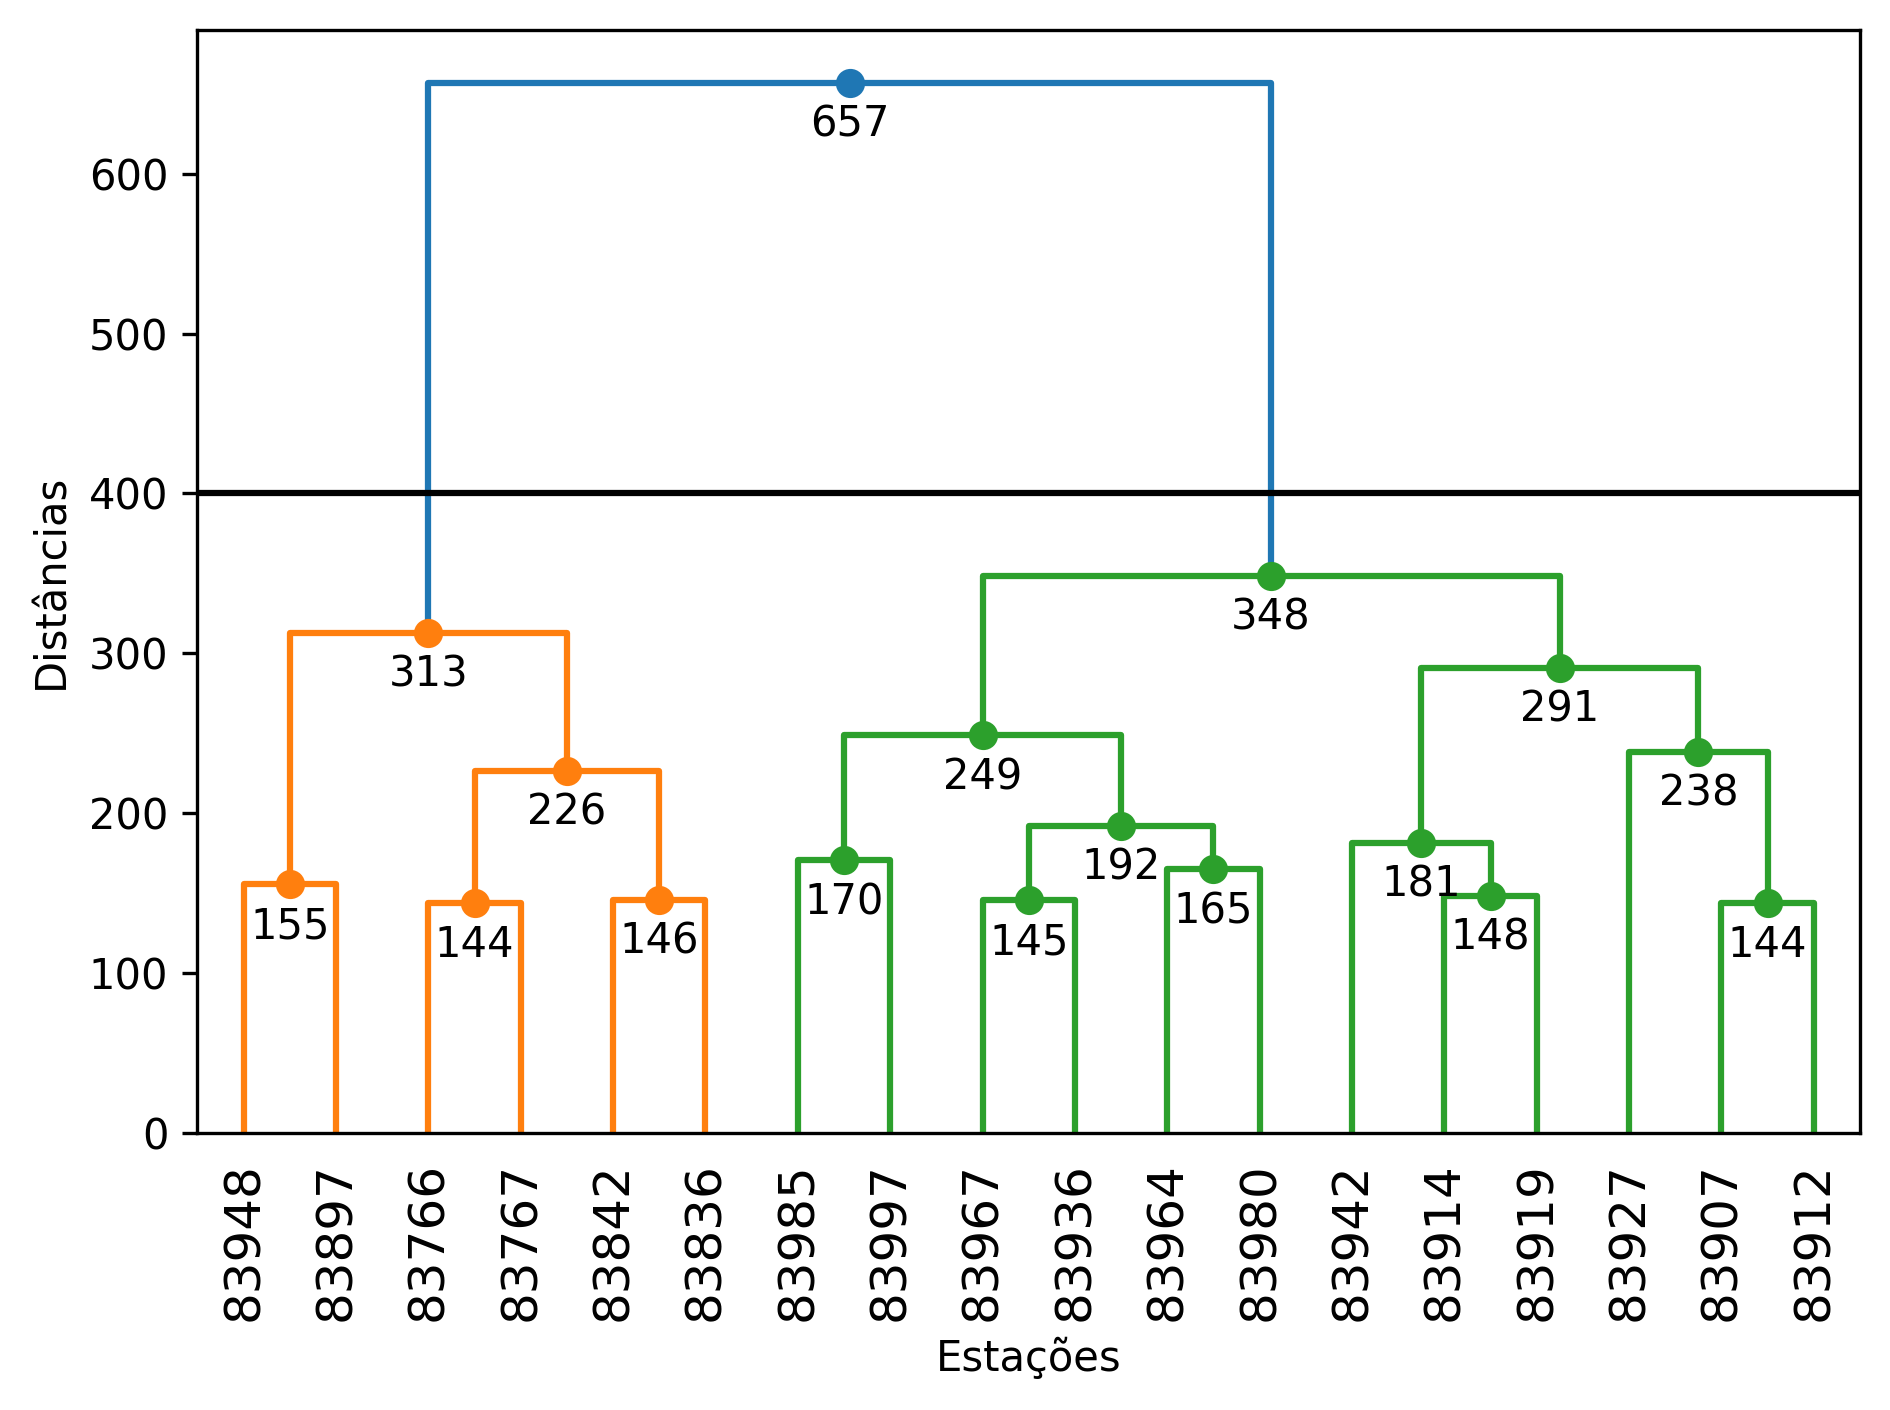

In [123]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

labels = list(anom_data.index)
max_d = 400
#350
#380
#312
#330
#410
#240 7grupos
Z = linkage(anom_data.values, 'ward')
clusters = fcluster(Z,max_d,criterion='distance')
#clusters = fcluster(Z,t=8,criterion='maxclust')


fig = plt.figure(dpi=300)
ax1 = plt.subplot(111)
#ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
# = ax.ravel()
D = fancy_dendrogram(
    ax1,
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
    labels=labels,
)

code2group = dict(zip(
    D['ivl'], 
    [c.replace('C','G') for c in D['leaves_color_list']]
))
group2color = {'G1': 'orange', 'G2': 'green', 'G3': 'red', 'G4': 'purple', 'G5': 'brown', 'G6': 'pink', 'G7':'gray'}

def get_groups(group):
    return [k for k, v in code2group.items() if v == group]

#groups_ward = anom_data.copy()
groups_ward = tmean_data.copy()

groups_ward['groups'] = None
for code, _df in groups_ward.iterrows():
    groups_ward.loc[code,'groups'] = code2group.get(code)

groups_ward = groups_ward.groupby('groups').mean().T
groups_ward.index = pd.to_datetime(groups_ward.index)
groups_ward = pd.DataFrame(groups_ward.values, index=groups_ward.index, columns=list(groups_ward.columns))




#ax1.annotate('A)', xy=(-0.1, 1), xycoords='axes fraction', color='black', fontsize=16)
    
#fig.colorbar(contourf, ax=ax2)
plt.savefig('images/dendrogram.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

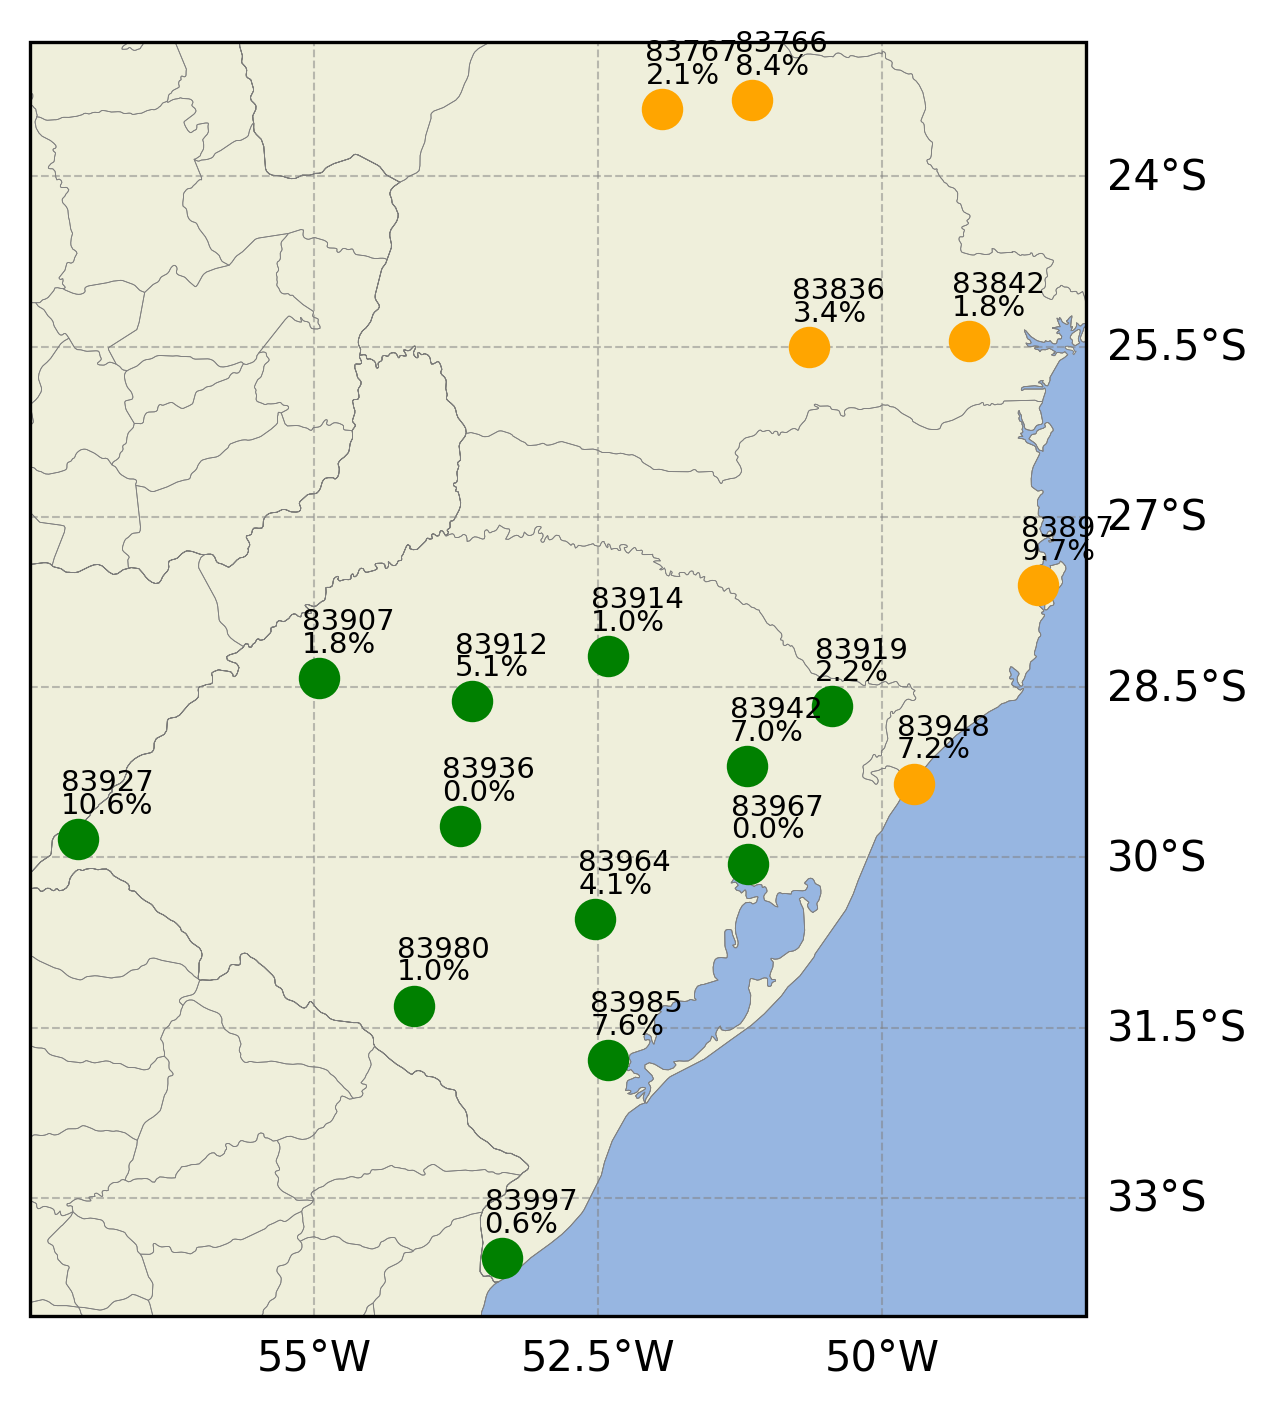

In [128]:
fig = plt.figure(dpi=300)
ax2 = plt.subplot(111, projection=ccrs.PlateCarree())
#ax2.set_extent([-60, -45, -35, -20], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, edgecolor='gray', linewidths=0.2)
ax2.add_feature(cfeature.BORDERS, linewidths=0.2)
ax2.add_feature(cfeature.OCEAN, edgecolor='gray', linewidths=0.2)
ax2.add_feature(cfeature.STATES, edgecolor='gray', linewidths=0.2)

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-55, -34, -52.5, -26, -50])
gl.left_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

#ax2.add_feature(cfeature.STATES, edgecolor='gray', linewidths=0.2)
min_lon, max_lon, min_lat, max_lat = extent

# z = xr.open_dataset('/media/lucaspc/HD/statics/etopo_0p01.nc')['z']
# z = xr.where(z<0, np.nan, z)
# z = z.sel(longitude=slice(min_lon, max_lon), latitude=slice(min_lat, max_lat))

# z_gaussian = gaussian_filter(z, sigma=2)

# contourf = ax2.contourf(z.longitude, z.latitude, z_gaussian, alpha=0.5, cmap='terrain', levels=np.arange(200,1200,150))#
#, linestyles='--', linewidths=0.2)
#ax2.clabel(contour, inline=True, inline_spacing=5, fontsize=10, fmt='%1.0f', colors='black', zorder=99)


marker = 'o'
for code, row in cidades.iterrows():
    
    color = group2color.get(code2group.get(code))
        
    ax2.scatter(row['lons'], row['lats'],# transform=ccrs.PlateCarree(),
          color=color, s=80, zorder=5, marker=marker)
    ax2.text(row['lons']-0.15, row['lats']+0.3, str(row['percent_null']) + '%',
            #transform=ccrs.PlateCarree(),
            fontsize=7, 
            color='black', zorder=100,
            verticalalignment='center')
    ax2.text(row['lons']-0.15, row['lats']+0.5, code,
            #transform=ccrs.PlateCarree(),
            fontsize=7,
            color='black', zorder=100,
            verticalalignment='center')
    
#ax2.annotate('B)', xy=(-0.05, 1), xycoords='axes fraction', color='black', fontsize=16)
    
#fig.colorbar(contourf, ax=ax2)
plt.savefig('images/stations.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

/tmp/ipykernel_5491/152975924.py:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  values_ward = groups_ward.resample('Y').mean()


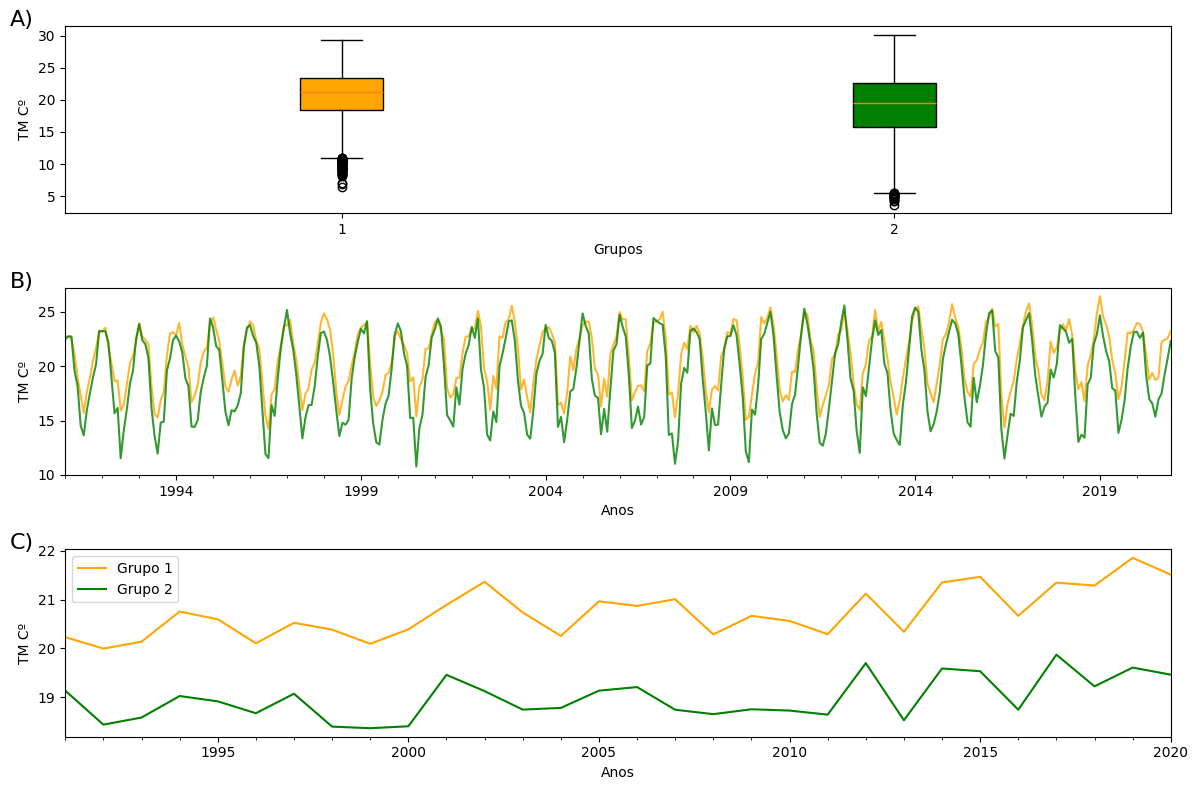

In [70]:
fig, ax = plt.subplots(3,1, figsize=(12,8), sharey=False, sharex=False)

values_ward = groups_ward.resample('ME').mean()
values_ward['G1'].plot(ax=ax[1], alpha=0.8, label='Grupo 1', color=group2color.get('G1'))
values_ward['G2'].plot(ax=ax[1], alpha=0.8, label='Grupo 2', color=group2color.get('G2'))
# values_ward['G3'].plot(ax=ax[1], alpha=0.8, label='Grupo 3', color=group2color.get('G3'))
# values_ward['G4'].plot(ax=ax[1], alpha=1, label='Grupo 4', color=group2color.get('G4'))
# values_ward['G5'].plot(ax=ax[1], alpha=1, label='Grupo 5', color=group2color.get('G5'))
# values_ward['G6'].plot(ax=ax[1], alpha=1, label='Grupo 6', color=group2color.get('G6'))
# values_ward['G7'].plot(ax=ax[6], alpha=1, subplots=False, figsize=(14,8), xlabel='Anos', label='Grupo 7', color=group2color.get('G7'))

values_ward = groups_ward.resample('Y').mean()
values_ward['G1'].plot(ax=ax[2], alpha=1, label='Grupo 1', color=group2color.get('G1'))
values_ward['G2'].plot(ax=ax[2], alpha=1, label='Grupo 2', color=group2color.get('G2'))
# values_ward['G3'].plot(ax=ax[2], alpha=1, label='Grupo 3', color=group2color.get('G3'))
# values_ward['G4'].plot(ax=ax[2], alpha=1, label='Grupo 4', color=group2color.get('G4'))
# values_ward['G5'].plot(ax=ax[2], alpha=1, label='Grupo 5', color=group2color.get('G5'))
# values_ward['G6'].plot(ax=ax[2], alpha=1, label='Grupo 6', color=group2color.get('G6'))
# values_ward['G7'].plot(ax=ax[6], alpha=1, subplots=False, figsize=(14,8), xlabel='Anos', label='Grupo 7', color=group2color.get('G7'))


values_ward = groups_ward
#ax[2].boxplot([values_ward['G1'], values_ward['G2'], values_ward['G3'], values_ward['G4'], values_ward['G5'], values_ward['G6']])
colors = ['orange', 'green', 'red', 'purple', 'brown', 'pink']

# Criando o boxplot
box = ax[0].boxplot(
    [values_ward['G1'], values_ward['G2']],# values_ward['G4']],# values_ward['G5']],#, values_ward['G6']],
    patch_artist=True  # Permite modificar as cores das caixas
)

# Aplicando cores individuais para cada boxplot
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
ax[0].set_xlabel('Grupos')
ax[0].set_ylabel('TM Cº')
ax[0].annotate('A)', xy=(-0.05, 1), xycoords='axes fraction', color='black', fontsize=16)


ax[1].set_ylabel('TM Cº')
ax[1].set_xlabel('Anos')
ax[1].annotate('B)', xy=(-0.05, 1), xycoords='axes fraction', color='black', fontsize=16)



ax[2].annotate('C)', xy=(-0.05, 1), xycoords='axes fraction', color='black', fontsize=16)
ax[2].set_xlabel('Anos')
ax[2].set_ylabel('TM Cº')
ax[2].legend(loc='best')

plt.tight_layout()
# ax[6].legend(loc='upper left')
plt.savefig('monthly_and_yearly_mean_groups_temperature_kmeans.pdf', format='pdf', bbox_inches='tight')

/tmp/ipykernel_5491/970308652.py:5: FutureWarning: 'me' is deprecated and will be removed in a future version, please use 'ME' instead.
  values_kmeans = groups_ward.resample('me').mean()


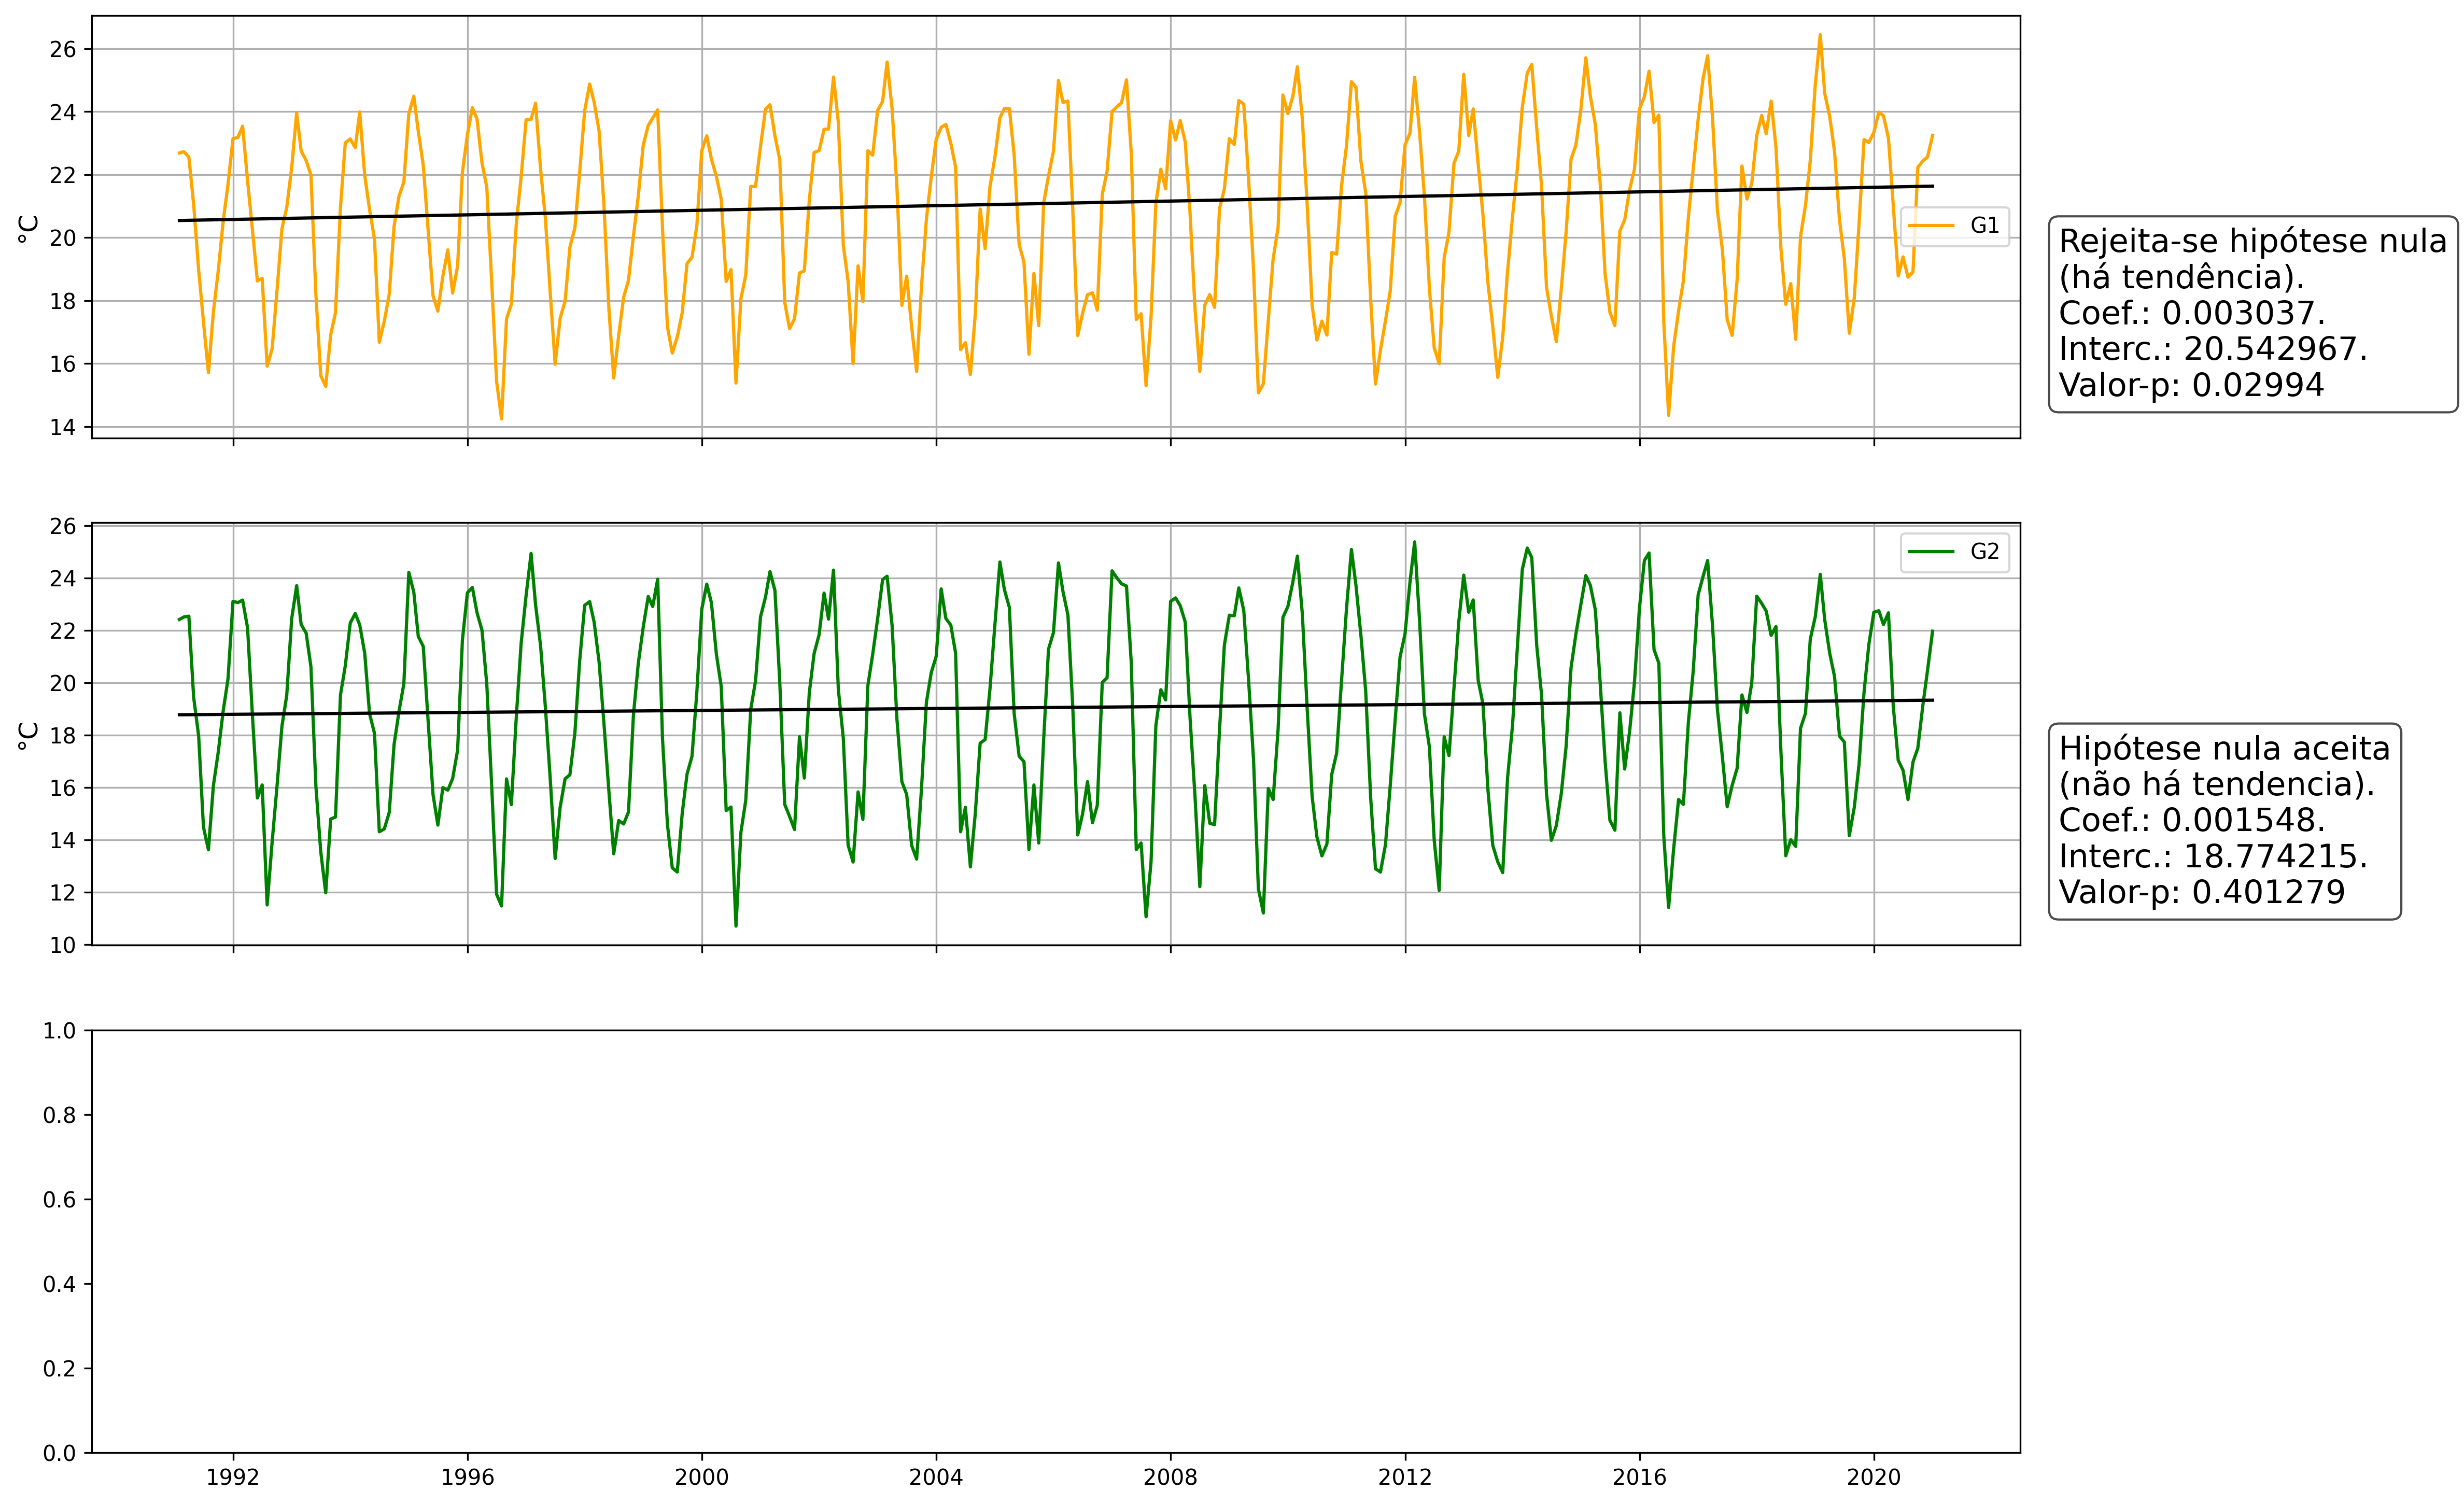

In [33]:
import pymannkendall as mk

fig, ax = plt.subplots(3,1, figsize=(16,12), dpi=300, sharey=False, sharex=True)

values_kmeans = groups_ward.resample('me').mean()

ax[0].plot(values_kmeans.loc[:, 'G1'].index, values_kmeans.loc[:, 'G1'], label='G1', color=group2color.get('G1'))
resultado = mk.original_test(values_kmeans.loc[:, 'G1'], alpha=0.05)
if resultado.trend == 'increasing':
    label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
else:
    label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
trend_line = np.arange(len(values_kmeans.loc[:, 'G1'])) * resultado.slope + resultado.intercept
ax[0].plot(values_kmeans.loc[:, 'G1'].index, trend_line, color='black')

x, y = 1.02, 0.1
ax[0].annotate(
    label, 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[0].set_ylabel('°C', fontsize=12)
#ax[0].set_ylim(-4,4)
ax[0].grid()
ax[0].legend(loc='right')

ax[1].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G2'], label='G2', color=group2color.get('G2'))
resultado = mk.original_test(values_kmeans.loc[:, 'G2'], alpha=0.05)
if resultado.trend == 'increasing':
    label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
else:
    label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
trend_line = np.arange(len(values_kmeans.loc[:, 'G2'])) * resultado.slope + resultado.intercept
ax[1].plot(values_kmeans.loc[:, 'G2'].index, trend_line, color='black')

x, y = 1.02, 0.1
ax[1].annotate(
    label, 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[1].set_ylabel('°C', fontsize=12)
#ax[1].set_ylim(-4,4)
ax[1].grid()
ax[1].legend()

# ax[2].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G3'], label='G3', color=group2color.get('G3'))
# resultado = mk.original_test(values_kmeans.loc[:, 'G3'], alpha=0.05)
# if resultado.trend == 'increasing':
#     label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
# else:
#     label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
# trend_line = np.arange(len(values_kmeans.loc[:, 'G3'])) * resultado.slope + resultado.intercept
# ax[2].plot(values_kmeans.loc[:, 'G3'].index, trend_line, color='black')

# x, y = 1.02, 0.1
# ax[2].annotate(
#     label, 
#     xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
#     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

# ax[2].set_ylabel('°C', fontsize=12)
# #ax[2].set_ylim(-4,4)
# ax[2].grid()
# ax[2].legend()

# ax[3].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G4'], label='G4', color=group2color.get('G4'))
# resultado = mk.original_test(values_kmeans.loc[:, 'G4'], alpha=0.05)
# if resultado.trend == 'increasing':
#     label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
# else:
#     label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
# trend_line = np.arange(len(values_kmeans.loc[:, 'G4'])) * resultado.slope + resultado.intercept
# ax[3].plot(values_kmeans.loc[:, 'G4'].index, trend_line, color='black')

# x, y = 1.02, 0.1
# ax[3].annotate(
#     label, 
#     xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
#     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

# ax[3].set_ylabel('°C', fontsize=12)
# #ax[3].set_ylim(-4,4)
# ax[3].grid()
# ax[3].legend()

# ax[4].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G5'], label='G5', color=group2color.get('G5'))
# resultado = mk.original_test(values_kmeans.loc[:, 'G5'], alpha=0.05)
# if resultado.trend == 'increasing':
#     label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
# else:
#     label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
# trend_line = np.arange(len(values_kmeans.loc[:, 'G5'])) * resultado.slope + resultado.intercept
# ax[4].plot(values_kmeans.loc[:, 'G5'].index, trend_line, color='black')

# x, y = 1.02, 0.1
# ax[4].annotate(
#     label, 
#     xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
#     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

# ax[4].set_ylabel('°C', fontsize=12)
# #ax[4].set_ylim(-4,4)
# ax[4].grid()
# ax[4].legend()


# ax[5].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G6'], label='G6', color=group2color.get('G6'))
# resultado = mk.original_test(values_kmeans.loc[:, 'G6'], alpha=0.05)
# if resultado.trend == 'increasing':
#     label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
# else:
#     label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
# trend_line = np.arange(len(values_kmeans.loc[:, 'G6'])) * resultado.slope + resultado.intercept
# ax[5].plot(values_kmeans.loc[:, 'G6'].index, trend_line, color='black')

# x, y = 1.02, 0.1
# ax[5].annotate(
#     label, 
#     xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
#     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

# ax[5].set_ylabel('°C', fontsize=12)
# #ax[5].set_ylim(-4,4)
# ax[5].grid()
# ax[5].legend()


# ax[6].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G7'], label='G7', color=group2color.get('G7'))
# resultado = mk.original_test(values_kmeans.loc[:, 'G7'], alpha=0.05)

# if resultado.trend == 'increasing':
#     label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
# else:
#     label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
# trend_line = np.arange(len(values_kmeans.loc[:, 'G7'])) * resultado.slope + resultado.intercept
# ax[6].plot(values_kmeans.loc[:, 'G7'].index, trend_line, color='black')

# x, y = 1.02, 0.1
# ax[6].annotate(
#     label, 
#     xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
#     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

# ax[6].set_ylabel('°C', fontsize=12)
# ax[6].set_xlabel('Anos')
# #ax[6].set_ylim(-4,4)
# ax[6].grid()
# ax[6].legend()

#plt.savefig('tendencia_anomalias_grupos.pdf', format='pdf', bbox_inches='tight')


In [ ]:
anom_mean = extract(codes, df_done, variable='anom_mean', fillna=True)
tmean = extract(codes, df_done, variable='tmean', fillna=True)
mean = extract(codes, df_done, variable='mean', fillna=True)

teste = tmean.loc['83936'] - mean.loc['83936'] == anom_mean.loc['83936'].values

In [ ]:
tmean_fillna = extract(codes, df_done, variable='tmean', fillna=True)

In [ ]:
tmean_fillna.T.plot(subplots=True, figsize=(16, 12), sharey=True, xlabel='Anos');

In [ ]:
df_done[(df_done.cod=='83920')].loc['2011', 'mean'].plot()

In [ ]:
tmean_fillna.loc['83920', :]

In [ ]:
tmean_groups = pd.DataFrame({'G1':tmean.T[get_groups('G1')].mean(axis=1), 
                             'G2':tmean.T[get_groups('G2')].mean(axis=1), 
                             'G3':tmean.T[get_groups('G3')].mean(axis=1)} 
                             )

mean_groups = pd.DataFrame({'G1':mean.T[get_groups('G1')].mean(axis=1), 
                             'G2':mean.T[get_groups('G2')].mean(axis=1), 
                             'G3':mean.T[get_groups('G3')].mean(axis=1)} 
                             )

anom_mean_groups = pd.DataFrame({'G1':anom_mean.T[get_groups('G1')].mean(axis=1), 
                             'G2':anom_mean.T[get_groups('G2')].mean(axis=1), 
                             'G3':anom_mean.T[get_groups('G3')].mean(axis=1)} 
                             )

In [ ]:
tmean_groups.to_csv('data/pos/filled_tmean_groups_kmeans.csv')

In [ ]:
mean_groups.to_csv('data/pos/filled_tmean_clim_groups_kmeans.csv')

In [ ]:
anom_mean_groups.to_csv('data/pos/filled_tmean_anomaly_groups_kmeans.csv')

In [ ]:
tmean_data

In [ ]:
tmean_groups.resample('1y').mean().plot()